In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [6]:
# Load your data (replace 'your_data.csv' with your actual file)
data = pd.read_csv(r"Datasets\food-contamination-data-cleaned-2.csv")

# Define X and Y
X = data.drop('ResultValue', axis=1) # All columns except ResultValue
y = data['ResultValue'] # The ResultValue column

In [7]:
# Identify categorical and numerical columns (assuming you've done this before)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Create preprocessor (assuming you've done this before)
numerical_transformer = 'passthrough'
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

In [8]:
# Create transformers for categorical and numerical columns
numerical_transformer = 'passthrough' # No transformation needed for numerical

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline with preprocessing and the linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [10]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)   

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1704.746408723103
R-squared: 0.04655158721223818


Since the r2 value is very low, the data is not related in a linear manner. it must be regularised. L1 / Lasso Regularisation is being used below

In [11]:
# Create Lasso model in a pipeline
lasso_model = Pipeline(steps=[('preprocessor', preprocessor), 
                              ('regressor', Lasso())])

# Define the parameter grid for alpha tuning
param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create GridSearchCV object for cross-validation
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object
grid_search_lasso.fit(X_train, y_train)

# Print the best alpha value
print(f'Best Lasso alpha: {grid_search_lasso.best_params_["regressor__alpha"]}')

# Get the best Lasso model
best_lasso_model = grid_search_lasso.best_estimator_

c:\Users\Ananya\Documents\GitHub\SafeBite\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23035910.87468704, tolerance: 6983.133609285355
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\Ananya\Documents\GitHub\SafeBite\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22958295.30327101, tolerance: 6951.078707136703
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\Ananya\Documents\GitHub\SafeBite\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22855603.947489653, tolerance: 6909.2075906941345
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\Ananya\D

Best Lasso alpha: 0.001


c:\Users\Ananya\Documents\GitHub\SafeBite\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28728446.119015217, tolerance: 8680.279789380971
  model = cd_fast.sparse_enet_coordinate_descent(


In [12]:
# Evaluate the best Lasso model on the test set
y_pred_lasso = best_lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Lasso MSE: {mse_lasso}')
print(f'Lasso R-squared: {r2_lasso}')

Lasso MSE: 1188.1131293703013
Lasso R-squared: 0.3354996546032245


While the MSE value has lowered, the deviation is still much to large.
R2 values indicate that the model is not able to explain 66% of the variance in contamination

Next approach:
1. transformations
2. decision tree regressors

For transformations:
1. Visualise using histogram
2. try log transformation 
3. if doesnt work, try box-cox or yeo-johnson

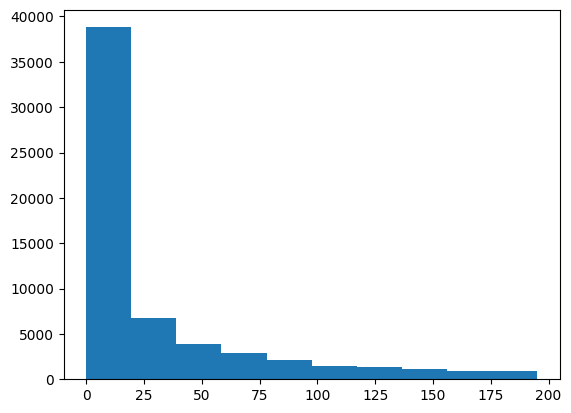

In [13]:
plt.hist(data['ResultValue'])
plt.show()

Since the data is heavily skewed to the right, we'll first perform log transformation and train the model

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply log transformation to the target variable (y)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#run the preprocessing cell after this if necessary

In [15]:
# Create Decision Tree Regressor model in a pipeline
decision_tree_log_model = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', DecisionTreeRegressor(random_state=42))])

# Train the model on the log-transformed target variable
decision_tree_log_model.fit(X_train, y_train_log)

# Make predictions on the test set
y_pred_log = decision_tree_log_model.predict(X_test)

# Inverse transform the predictions back to the original scale
y_pred_original_scale = np.expm1(y_pred_log)

In [16]:
# Evaluate the model on the original scale predictions
mse_log = mean_squared_error(y_test, y_pred_original_scale)
r2_log = r2_score(y_test, y_pred_original_scale)

print("Results with Log Transformation:")
print(f'Decision Tree MSE (Original Scale): {mse_log}')
print(f'Decision Tree R-squared (Original Scale): {r2_log}')

Results with Log Transformation:
Decision Tree MSE (Original Scale): 902.5868017951003
Decision Tree R-squared (Original Scale): 0.495191807314433


In [17]:
# You can also train and evaluate a model without log transformation for comparison
decision_tree_original_model = Pipeline(steps=[('preprocessor', preprocessor),
                                              ('regressor', DecisionTreeRegressor(random_state=42))])
decision_tree_original_model.fit(X_train, y_train)
y_pred_original = decision_tree_original_model.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print("\nResults without Log Transformation:")
print(f'Decision Tree MSE (Original Scale): {mse_original}')
print(f'Decision Tree R-squared (Original Scale): {r2_original}')   


Results without Log Transformation:
Decision Tree MSE (Original Scale): 904.4470350562799
Decision Tree R-squared (Original Scale): 0.49415139658752905


In [18]:
#User testing block

def predict_contamination(user_input_dict, best_model, numerical_cols, categorical_cols):
    """
    Predicts the contamination level based on user input.

    Args:
        user_input_dict (dict): A dictionary containing the user's input
                                 for the features (keys should match column names).
        best_model (Pipeline): The trained best Decision Tree Regressor model.
        numerical_cols (list): List of numerical column names.
        categorical_cols (list): List of categorical column names.

    Returns:
        float: The predicted contamination level (original scale).
    """
    user_input_df = pd.DataFrame([user_input_dict])

    # Ensure all necessary columns are present (handle missing if needed)
    for col in numerical_cols:
        if col not in user_input_df.columns:
            user_input_df[col] = 0  # Or some other appropriate default

    for col in categorical_cols:
        if col not in user_input_df.columns:
            user_input_df[col] = 'unknown'  # Or some other appropriate default

    # Preprocess the user input using the same preprocessor in the pipeline
    preprocessed_input = best_model.named_steps['preprocessor'].transform(user_input_df)

    # Make prediction (which will be on the log scale)
    predicted_log = best_model.named_steps['regressor'].predict(preprocessed_input)

    # Inverse transform the prediction to the original scale
    predicted_original_scale = np.expm1(predicted_log)[0]  # [0] to get the single prediction

    return predicted_original_scale

# Example user input
user_input = {
    'FoodID': 123,
    'CountryName': 'USA',
    'FoodGroupName': 'Fruits',
    'GEMSFoodName': 'Apples',
    'ContaminantID': 45,
    'ContaminantName': 'Pesticide X',
    'Year': 2024,
    'ContaminationIndividualID': 789  # Include if it was part of your features
}

#update before every test
model_to_be_tested = decision_tree_log_model

# Get the prediction
prediction = predict_contamination(user_input, model_to_be_tested, numerical_cols, categorical_cols)

print(f"Predicted Contamination Level: {prediction:.2f} micrograms/kg")

Predicted Contamination Level: 1.00 micrograms/kg


In [19]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply log transformation to the target variable (y_train and y_test)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Identify categorical and numerical columns (assuming you've done this)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Create preprocessor (assuming you've done this)
numerical_transformer = 'passthrough'
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

# Create the Decision Tree Regressor pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', DecisionTreeRegressor(random_state=42))])

# Define the hyperparameter grid to search
param_grid = {
    'regressor__max_depth': [None, 5, 10, 15, 20],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 3, 5, 10],
    'regressor__max_features': ['sqrt', 'log2', None]  # None means consider all features
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data (using the log-transformed target)
grid_search.fit(X_train, y_train_log)

# Print the best hyperparameters found
print(f"Best hyperparameters: {grid_search.best_params_}")

# Get the best model from GridSearchCV
best_decision_tree_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_log_tuned = best_decision_tree_model.predict(X_test)

# Inverse transform the predictions back to the original scale
y_pred_original_scale_tuned = np.expm1(y_pred_log_tuned)

Best hyperparameters: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 10, 'regressor__min_samples_split': 2}


In [20]:
# Evaluate the best model on the original scale predictions
mse_tuned = mean_squared_error(y_test, y_pred_original_scale_tuned)
r2_tuned = r2_score(y_test, y_pred_original_scale_tuned)

print("\nResults with Tuned Decision Tree (Log Transformed Target):")
print(f'Decision Tree MSE (Original Scale): {mse_tuned}')
print(f'Decision Tree R-squared (Original Scale): {r2_tuned}')


Results with Tuned Decision Tree (Log Transformed Target):
Decision Tree MSE (Original Scale): 691.1721707067279
Decision Tree R-squared (Original Scale): 0.6134339947857661


The model is performing better, to further optimise it, we evaluate feature importance. It tells us which feature influences the result the most

In [21]:
feature_importances = best_decision_tree_model.named_steps['regressor'].feature_importances_

# Get the feature names (after one-hot encoding)
feature_names = best_decision_tree_model.named_steps['preprocessor'].get_feature_names_out()

# Create a dictionary to map feature names to their importance
importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance (descending)
sorted_importances = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

Feature Importances:
num__ContaminationIndividualID: 0.4864
num__ContaminantID: 0.3533
cat__CountryName_China: 0.0611
cat__CountryName_Singapore: 0.0276
num__Year: 0.0162
cat__ContaminantName_Lead: 0.0064
num__FoodID: 0.0061
cat__GEMSFoodName_FISHES: 0.0051
cat__CountryName_HONG KONG SAR: 0.0051
cat__CountryName_Republic of Korea: 0.0044
cat__ContaminantName_Iodine 131: 0.0040
cat__GEMSFoodName_Cattle milk: 0.0020
cat__FoodGroupName_Fruit and fruit products: 0.0018
cat__GEMSFoodName_Rays: 0.0017
cat__ContaminantName_Other: 0.0017
cat__GEMSFoodName_Flounders: 0.0016
cat__GEMSFoodName_MEAT FROM MAMMALS OTHER THAN MARINE MAMMALS: 0.0012
cat__FoodGroupName_Vegetables and vegetable products (including fungi): 0.0012
cat__GEMSFoodName_Pollack: 0.0012
cat__CountryName_Thailand: 0.0010
cat__FoodGroupName_Meat and meat products (including edible offal): 0.0009
cat__GEMSFoodName_Starchy roots and tubers NES: 0.0008
cat__GEMSFoodName_Mushrooms: 0.0008
cat__ContaminantName_Cadmium: 0.0006
cat__Foo

While the model is working well, a random forest regressor may work better.

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply log transformation to the target variable (y_train and y_test)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Identify categorical and numerical columns (assuming you've done this)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Create preprocessor (assuming you've done this)
numerical_transformer = 'passthrough'
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

# Create the Random Forest Regressor pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42))])

In [ ]:
# Define the hyperparameter grid to search for Random Forest
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__max_features': ['sqrt', 'log2']
}

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data (using the log-transformed target)
grid_search_rf.fit(X_train, y_train_log)

In [ ]:
# Print the best hyperparameters found for Random Forest
print(f"Best hyperparameters for Random Forest: {grid_search_rf.best_params_}")

# Get the best Random Forest model from GridSearchCV
best_random_forest_model = grid_search_rf.best_estimator_

# Make predictions on the test set using the best Random Forest model
y_pred_log_rf_tuned = best_random_forest_model.predict(X_test)

# Inverse transform the predictions back to the original scale
y_pred_original_scale_rf_tuned = np.expm1(y_pred_log_rf_tuned)


In [ ]:
# Evaluate the best Random Forest model on the original scale predictions
mse_rf_tuned = mean_squared_error(y_test, y_pred_original_scale_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_original_scale_rf_tuned)

print("\nResults with Tuned Random Forest (Log Transformed Target):")
print(f'Random Forest MSE (Original Scale): {mse_rf_tuned}')
print(f'Random Forest R-squared (Original Scale): {r2_rf_tuned}')